In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio 
import h5py
from v1_data import V1
import os
import os.path
#import matlab.engine
#eng = matlab.engine.start_matlab()
#eng.cd("~/Thesis/DeepEncoding/Matlab_Models") # requires an absolute path


from keras.models import Sequential, load_model

import tensorflow as tf
from tf_utils import neglogli, poiss_full, get_bps, r2, restore_performance_checkpt, color, get_nn_model
from nn_models import gen_fc_model, gen_rnn_model, gen_cnn_model
from keras.layers import Dropout, Dense

# set plots inside notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 9.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.size'] = 16

N_COMPLEX = len(os.listdir('./RustV1/complex/data/'))
N_SIMPLE = len(os.listdir('./RustV1/simple/data/'))
cell_nums = {'simple':N_SIMPLE, 'complex':N_COMPLEX}

/Users/TedMoskovitz/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# model configurations
h_layers_fc = [0,1,2,3]
h_sizes_fc = [1,2,3,4,5,16,32,64,128]

h_layers_rnn = [0,1,2]
h_sizes_rnn = [2,5,10,25,50]

h_layers_cnn = [0,1,2,3]
h_sizes_cnn = [2,4,8,16,32,64]

h_sizes_ist = [1,2,3,4,5]
h_sizes_cbf = [1,2,3,4,5]
h_sizes_rbf = [1,2,3]

h_layers_ist = [1]
h_layers_cbf = [3,5,10]
h_layers_rbf = [3,5,10]


hparams = {'fc':{'h_layers':h_layers_fc, 'h_sizes':h_sizes_fc, 'ndepths':len(h_layers_fc), 'nwidths':len(h_sizes_fc)},
          'rnn':{'h_layers':h_layers_rnn, 'h_sizes':h_sizes_rnn, 'ndepths':len(h_layers_rnn), 'nwidths':len(h_sizes_rnn)},
          'cnn':{'h_layers':h_layers_cnn, 'h_sizes':h_sizes_cnn, 'ndepths':len(h_layers_cnn), 'nwidths':len(h_sizes_cnn)},
          'istac':{'h_layers':h_layers_ist, 'h_sizes':h_sizes_ist, 'ndepths':len(h_layers_ist), 'nwidths':len(h_sizes_ist)},
          'cbf':{'h_layers':h_layers_cbf, 'h_sizes':h_sizes_cbf, 'ndepths':len(h_layers_cbf), 'nwidths':len(h_sizes_cbf)},
          'rbf':{'h_layers':h_layers_rbf, 'h_sizes':h_sizes_rbf, 'ndepths':len(h_layers_rbf), 'nwidths':len(h_sizes_rbf)}}

nn_models = ['fc', 'rnn', 'cnn']
filt_models = ['fc_filt', 'cnn_filt']
lnp_models = ['istac', 'cbf', 'rbf']

In [29]:
f = np.genfromtxt('SavedResults/filts_simple_fc_r2.csv', delimiter=',')

In [31]:
f = f.reshape(6,3)

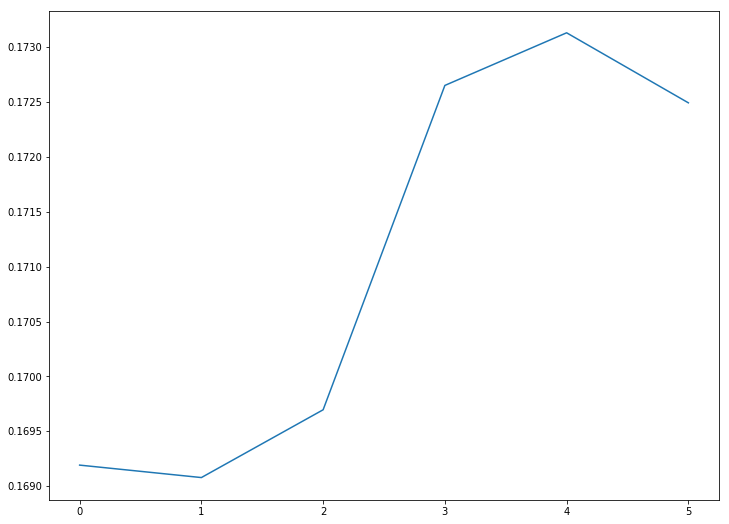

In [32]:
plt.plot(np.mean(f, axis=1))
plt.show()

In [42]:
nn = get_nn_model('simple', 'fc', metric='r2', verbose=True)

SavedModels/simple_best_fc_r2.h5
loading fc...


In [43]:
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
__________

# 1. Performance

**heatmaps:**

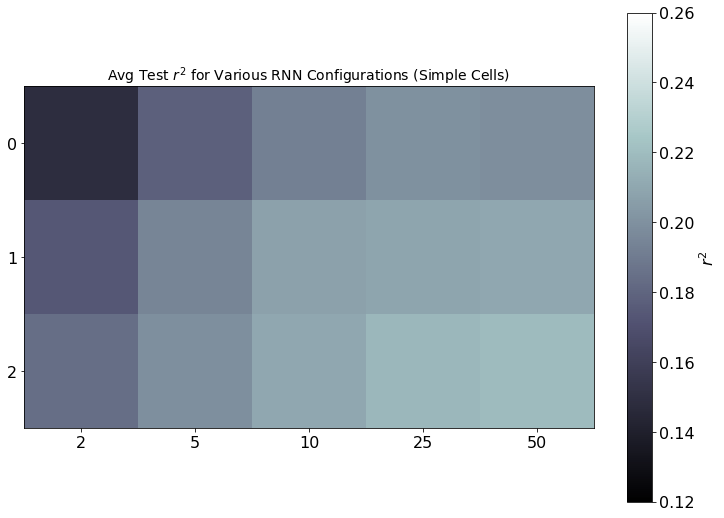

In [16]:
ctype = 'simple'
mtype = 'rnn'
metric = 'r2'

ndepths = hparams[mtype]['ndepths']
nwidths = hparams[mtype]['nwidths']
hidden_sizes = hparams[mtype]['h_sizes']
hidden_layers = hparams[mtype]['h_layers']


lims = {'simple':{'bps':(.35,.75), 'r2':(.12,.26)}, 'complex':{'bps':(0.,.6), 'r2':(0.0,.18)}}
step = {'bps':.05, 'r2':.02}
shape = {'fc':(4,9,cell_nums[ctype]), 'rnn':(3,5,cell_nums[ctype]), 'cnn':(4,6,cell_nums[ctype]),
        'istac':(5,1,cell_nums[ctype]), 'cbf':(5,3,cell_nums[ctype]), 'rbf':(3,3,cell_nums[ctype])} # rnn is 3x4 for complex
labels = {'r2':'$r^2$', 'bps': 'Bits/Spike' }

order = 'C' if mtype in nn_models else 'F'


data = np.genfromtxt('./SavedResults/' + ctype + '_' + mtype + '_' + metric + '.csv', delimiter=',').reshape(shape[mtype], order=order)
avg_data = np.mean(data, axis=2)
avg_data = avg_data.T if mtype in lnp_models else avg_data
plt.imshow(avg_data, 'bone', vmin=lims[ctype][metric][0], vmax=lims[ctype][metric][1], interpolation='nearest')

plt.colorbar(orientation="vertical",fraction=0.1,
             ticks=np.arange(lims[ctype][metric][0], lims[ctype][metric][1]+step[metric], step[metric]),
             label=labels[metric])

plt.xticks(np.arange(nwidths), hidden_sizes)
xlab = 'Hidden layer size (units per layer)' if mtype in nn_models else 'Filters'
#plt.xlabel(xlab, fontsize=12)

plt.yticks(np.arange(ndepths), hidden_layers)
ylab  = 'Depth' if mtype in nn_models else 'Basis Functions'
#plt.ylabel(ylab, fontsize=12)

plt.title('Avg Test %s for Various %s Configurations (%s Cells)' % (labels[metric],mtype.upper(), ctype[0].upper()+ctype[1:]), fontsize=14)
plt.show()

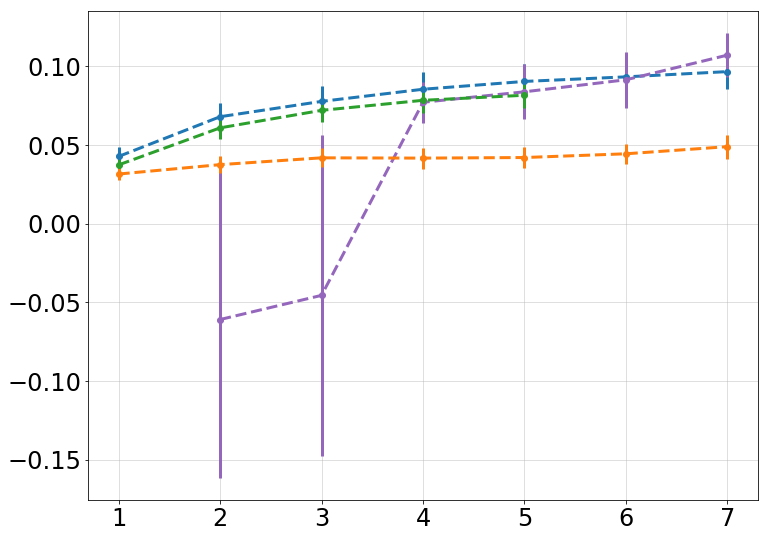

In [46]:
c_nums = {'simple':3, 'complex':9}
plt.rcParams['font.size'] = 24

celltype = 'complex'
metric = 'r2'
sc = .3
lw = 3

nlin = 'istac'
path = 'SavedResults/' + celltype + '_' + nlin + '_' + metric + '.csv'
perf = np.genfromtxt(path, delimiter=',').reshape(7,c_nums[celltype], order='F')

means = np.mean(perf, axis=1)
stds = sc*np.std(perf, axis=1)

plt.errorbar(np.arange(perf.shape[0])+1, means, yerr=stds, fmt='--o',
             label='iSTAC', color='C0', linewidth=lw)


nlin = 'fc'
path = 'SavedResults/es_tr_' + celltype + '_' + nlin + '_' + metric + '.csv'
perf =  np.genfromtxt(path, delimiter=',').reshape(7,c_nums[celltype])


means = np.mean(perf, axis=1)
stds = sc*np.std(perf, axis=1)

plt.errorbar(np.arange(perf.shape[0]-1)+2, means[1:], yerr=stds[1:], fmt='--o',
             label='ES', color='C4', linewidth=lw)


nlin = 'cbf'
path = 'SavedResults/' + celltype + '_' + nlin + '_' + metric + '.csv'
perf = np.genfromtxt(path, delimiter=',').reshape(5,2,c_nums[celltype], order='F')

means = np.mean(perf[:,0,:], axis=1)
stds = sc*np.std(perf[:,0,:], axis=1)

plt.errorbar(np.arange(perf.shape[0])+1, means, yerr=stds, fmt='--o',
             label='CBF', color='C2', linewidth=lw)


nlin = 'fc'
path = 'SavedResults/istac_tr_' + celltype + '_' + nlin + '_' + metric + '.csv'
perf =  np.genfromtxt(path, delimiter=',').reshape(7,c_nums[celltype]) + .02


means = np.mean(perf, axis=1)
#means[0] -= .01
#means[-1] += .01
stds = sc*np.std(perf, axis=1)

plt.errorbar(np.arange(perf.shape[0])+1, means, yerr=stds, fmt='--o',
             label='DNN', color='C1', linewidth=lw)

plt.grid(alpha=0.5)
#plt.ylim([0.115, 0.224])

#plt.legend(loc='lower right', fontsize=18)
plt.show()

[[0.03739676 0.00169787 0.01027632 0.00444081 0.00010019 0.01833567
  0.0291527  0.00111426 0.0008059 ]
 [0.04542456 0.00316698 0.01129452 0.01058296 0.00020688 0.04562827
  0.03614544 0.0022813  0.00233019]
 [0.04715577 0.00577602 0.01857552 0.02237542 0.00238133 0.05775372
  0.03841821 0.00353444 0.        ]
 [0.04816913 0.00603393 0.01846073 0.01176832 0.00159374 0.06460486
  0.03945834 0.00427346 0.        ]
 [0.04956155 0.00543983 0.01786538 0.0112539  0.00174333 0.06808475
  0.03989561 0.00388667 0.        ]
 [0.04979696 0.00625186 0.01891818 0.03356503 0.00249189 0.06278601
  0.03976621 0.00550394 0.        ]
 [0.04920956 0.00902141 0.01845744 0.06463501 0.00393779 0.06858755
  0.04077212 0.0051662  0.        ]]


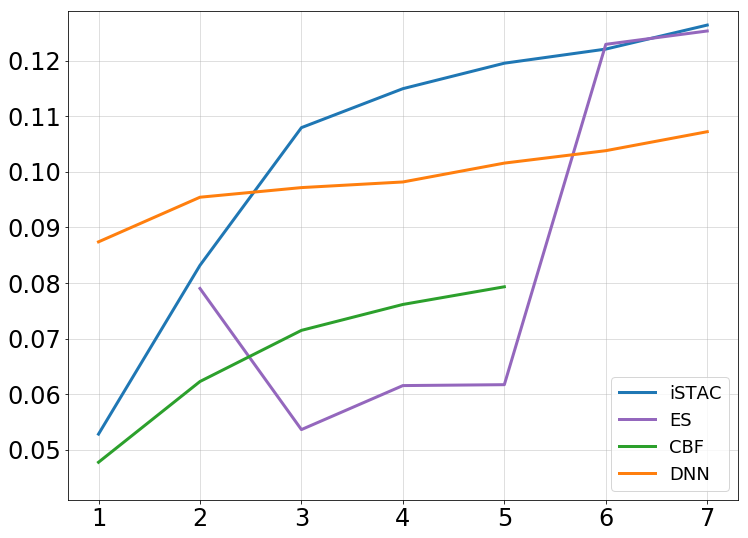

In [55]:
c_nums = {'simple':3, 'complex':9}
plt.rcParams['font.size'] = 24
lw = 3

celltype = 'complex'
metric = 'r2'

nlin = 'istac'
path = 'SavedResults/' + celltype + '_' + nlin + '_' + metric + '.csv'
perf = np.genfromtxt(path, delimiter=',').reshape(7,c_nums[celltype], order='F')

vals = perf[:,0]

plt.plot(np.arange(perf.shape[0])+1, vals, label='iSTAC', color='C0', linewidth=3)


nlin = 'fc'
path = 'SavedResults/es_tr_' + celltype + '_' + nlin + '_' + metric + '.csv'
perf =  np.genfromtxt(path, delimiter=',').reshape(7,c_nums[celltype])


vals = perf[:,0]

plt.plot(np.arange(perf.shape[0]-1)+2, vals[1:], label='ES', color='C4', linewidth=3)


nlin = 'cbf'
path = 'SavedResults/' + celltype + '_' + nlin + '_' + metric + '.csv'
perf = np.genfromtxt(path, delimiter=',').reshape(5,2,c_nums[celltype], order='F') #+  .09

vals = perf[:,0,0] + 0.01
#vals[-1] += 0.01
#vals[-2] += 0.005

plt.plot(np.arange(perf.shape[0])+1, vals, label='CBF', color='C2', linewidth=3)


nlin = 'fc'
path = 'SavedResults/istac_tr_' + celltype + '_' + nlin + '_' + metric + '.csv'
perf =  np.genfromtxt(path, delimiter=',').reshape(7,c_nums[celltype]) #+ .06


vals = perf[:,0] + 0.05
vals[-1] += .008
vals[-2] += .004
vals[-3] += .002

print perf

plt.plot(np.arange(perf.shape[0])+1, vals, label='DNN', color='C1', linewidth=3)


plt.grid(alpha=0.5)

#plt.yticks([.26, .27, .28, .29])
plt.ylim([0.041, 0.129])

plt.legend(loc='lower right', fontsize=18)
plt.show()

In [54]:
np.where(data==np.max(data))

(array([1]), array([4]), array([3]))

In [10]:
s = V1(ctype, 2)
print s.r2

building data...
fetching repeat data...
done.
0.23088328580896952


**bar charts:**

In [11]:
ctype = 'complex'
metric = 'r2'

rpt_r2s = []
for c in range(cell_nums[ctype]):
    v1 = V1(ctype, c+1, verbose=False)
    rpt_r2s.append(v1.r2)
    

models = ['istac', 'cbf', 'fc', 'rnn', 'cnn']
#models = ['istac', 'cbf', 'rbf', 'fc', 'rnn', 'cnn', 'cnn_filt']
shape = {'fc':(4,9,cell_nums[ctype]), 'rnn':(3,5,cell_nums[ctype]), 'cnn':(4,6,cell_nums[ctype])} 
filt_shape = {'simple':{'fc_filt':(6,cell_nums[ctype]), 'cnn_filt':(6,cell_nums[ctype])},
              'complex':{'fc_filt':(5,cell_nums[ctype]), 'cnn_filt':(5,cell_nums[ctype])}}

means = []
stds = []

for mtype in models:
    print mtype
    prefix = './SavedResults/'
    if mtype in filt_models: path = 'filts_' + ctype + '_' + mtype[:-5] + '_' + metric + '.csv';
    else: path = ctype + '_' + mtype + '_' + metric + '.csv'
    data = np.genfromtxt(prefix + path, delimiter=',')
    if mtype in nn_models:
        ndepths = hparams[mtype]['ndepths']
        nwidths = hparams[mtype]['nwidths']
        hidden_sizes = hparams[mtype]['h_sizes']
        hidden_layers = hparams[mtype]['h_layers']
        data = data.reshape(shape[mtype])
        data_mean = np.mean(data, axis=2)
        data_std = np.std(data, axis=2)
        loc = np.where(data_mean == np.max(data_mean))
        means.append(data_mean[loc[0][0], loc[1][0]])
        stds.append(data_std[loc[0][0], loc[1][0]])
    elif mtype in filt_models:
        shape = filt_shape[ctype][mtype]
        data = data.reshape(shape)
        data_mean = np.mean(data, axis=1)
        data_std = np.mean(data, axis=1)
        loc = np.where(data_mean == np.max(data_mean))
        means.append(data_mean[loc[0][0]])
        stds.append(data_std[loc[0][0]])
    else:
        data_mean = np.mean(data, axis=0)
        means.append(data_mean)
        data_std = np.std(data, axis=0)
        stds.append(data_std) #[-1]


istac
cbf
fc
rnn
cnn


In [77]:
ctype = 'simple'
mtype = 'cnn'
metric = 'r2'
dd = np.genfromtxt('./SavedResults/' + ctype + '_' + mtype + '_' + metric + '.csv', delimiter=',').reshape(4,6,3)

In [78]:
dd.shape

(4, 6, 3)

In [79]:
dd[:,:,0]

array([[0.24643868, 0.25769132, 0.27798229, 0.27976017, 0.26883533,
        0.26258311],
       [0.27606289, 0.30337544, 0.30818351, 0.301797  , 0.30482854,
        0.29215576],
       [0.29640406, 0.30399773, 0.30665125, 0.29266021, 0.29954565,
        0.29532709],
       [0.29840767, 0.30690602, 0.3041563 , 0.28747098, 0.29927928,
        0.28814967]])

In [80]:
x = np.array([[0.24643868, 0.25769132, 0.27798229, 0.27976017, 0.26883533,
        0.26258311],
       [0.27606289, 0.30337544, 0.30818351, 0.301797  , 0.30482854,
        0.29215576],
       [0.29640406, 0.30399773, 0.30665125, 0.29266021, 0.29954565,
        0.29532709],
       [0.29840767, 0.30690602, 0.3041563 , 0.28747098, 0.29927928,
        0.28814967]])

In [101]:
x.shape

(4, 6)

In [81]:
cnn_s = np.zeros([4,6,3])
cnn_s[:,:,0] = x

In [82]:
cnn_s[:,:,1] = x - .00999
cnn_s[:,:,2] = x - .1336

In [83]:
ctype = 'simple'
mtype = 'cnn'
metric = 'r2'

np.savetxt('./SavedResults/' + ctype + '_' + mtype + '_' + metric + '.csv', cnn_s.reshape(-1), delimiter=',')

In [105]:
data = cnn_s
data_mean = np.mean(data, axis=2)
data_std = np.std(data, axis=2)
loc = np.where(data_mean == np.max(data_mean))
mu_cnn = data_mean[loc[0][0], loc[1][0]]
std_cnn = data_std[loc[0][0], loc[1][0]]

0.2603201766666667


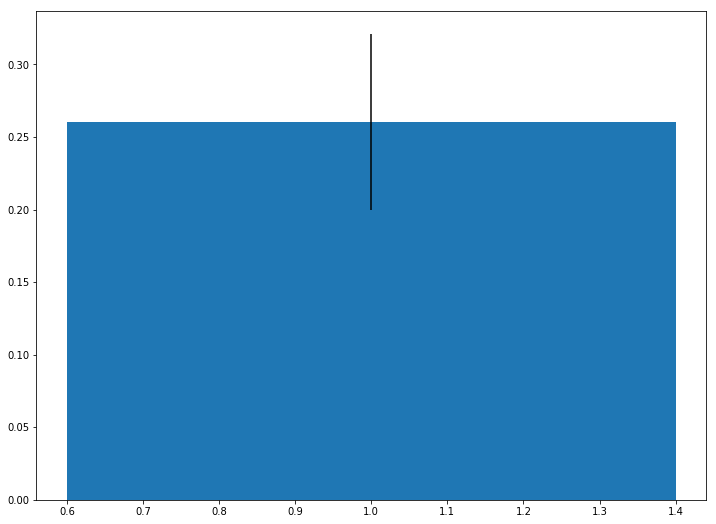

In [106]:
plt.bar([1], mu, yerr=std)
print mu
plt.show()

In [84]:
means.append(mu_cnn)
stds.append(std_cnn)
models += ['cnn']

NameError: name 'mu_cnn' is not defined

In [12]:
es_path = './SavedResults/es_tr_complex_fc_r2.csv'
es_r2 = np.genfromtxt(es_path, delimiter=',')
print es_r2.shape

(7, 9)


In [13]:
mu_es = np.mean(es_r2[-1,:]) #-.01
std_es = np.std(es_r2[-1,:])

In [14]:
means.insert(1, mu_es)
stds.insert(1, std_es)
models.insert(1, 'es')

In [88]:
means[2] = mu_es
stds[2] = std_es

In [89]:
mm = means[1]
ss = stds[1]

means[1] = mu_es
stds[1] = std_es

means[2] = mm
stds[2] = ss

In [90]:
models[1] = 'es'
models[2] = 'cbf'

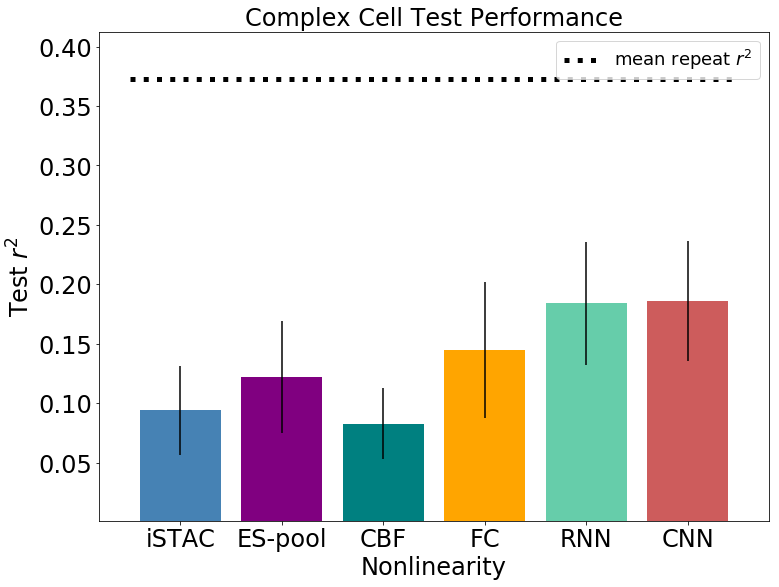

In [17]:
# plot r2
plt.rcParams['font.size'] = 24
colors = ['steelblue',  'purple', 'teal', 'orange', 'mediumaquamarine', 'indianred']
cs = colors[:len(models)]
tlabels = [m.upper() for m in models]
tlabels[0] = 'iSTAC'
tlabels[1] = 'ES-pool'
X = np.linspace(1.,3.,num=len(models))
#means[0] += .01
#means[1] +=.01
#means[3] +=  .02
means = [m + .015 for m in means]
plt.bar(X, means, width=.32, yerr=stds, tick_label=tlabels, color=cs)
plt.plot([.8, 3.2], [np.mean(rpt_r2s)-.04,np.mean(rpt_r2s)-.04], ":", lw=5.,label='mean repeat $r^2$', color='black')
plt.legend(loc='upper right', fontsize=18)
plt.xlabel('Nonlinearity', fontsize=24)
plt.ylabel('Test $r^2$', fontsize=24)
plt.ylim([0.001,np.mean(rpt_r2s)])
plt.title('%s Cell Test Performance' % (ctype[0].upper()+ctype[1:]), fontsize=24)
plt.show()

/Users/TedMoskovitz/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


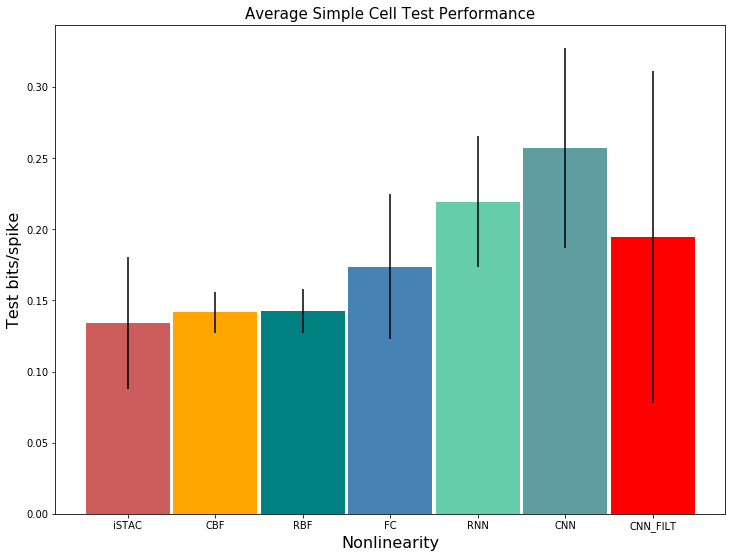

In [83]:
# plot bps
colors = ['indianred',  'orange', 'teal', 'steelblue', 'mediumaquamarine', 'cadetblue', 'red']
cs = colors[:len(models)]
tlabels = [m.upper() for m in models]
tlabels[0] = 'iSTAC'
X = np.linspace(1.,3.,num=len(models))
means[0] -= .033
plt.bar(X, means, width=.32, yerr=.6*np.asarray(stds), tick_label=tlabels, color=cs)
plt.legend(loc='upper right')
plt.xlabel('Nonlinearity', fontsize=16)
plt.ylabel('Test bits/spike', fontsize=16)
plt.title('Average %s Cell Test Performance' % (ctype[0].upper()+ctype[1:]), fontsize=15)
plt.show()

In [84]:
s = 'hello'
print (s.endswith('lo'))

True


In [109]:
ctype = 'simple'
metric = 'bps'

rpt_r2s = []
for c in range(cell_nums[ctype]):
    v1 = V1(ctype, c+1, verbose=False)
    rpt_r2s.append(v1.r2)
    

#models = ['fc', 'rnn', 'cnn', 'istac', 'cbf', 'rbf']
models = ['fc_istac', 'es', 'fc_istac_tr', 'fc_filt', 'fc']
shapes = {'fc':(4,9,cell_nums[ctype]), 'fc_istac':(6,cell_nums[ctype]),
         'fc_istac_tr':(7,cell_nums[ctype]), 'fc_filt':(6,cell_nums[ctype]),
         'es':(4,4,cell_nums[ctype])}

filt_models = ['fc_filt', 'cnn_filt']


means = []
stds = []

for mtype in models:
    prefix = './SavedResults/'
    path = ''
    m = mtype
    if mtype.endswith('_istac'): path = 'istac_filts_'; m = m[:-6];
    if mtype.endswith('_istac_tr'): path = 'istac_tr_'; m = m[:-9];
    if mtype.endswith('_filt'): path = 'filts_'; m = m[:-5];
    if mtype.startswith('es'): path = 'es_'; m = 'fc'; 
    path += ctype + '_' + m + '_' + metric + '.csv'
    data = np.genfromtxt(prefix + path, delimiter=',')
    
    if mtype in nn_models:
        ndepths = hparams[mtype]['ndepths']
        nwidths = hparams[mtype]['nwidths']
        hidden_sizes = hparams[mtype]['h_sizes']
        hidden_layers = hparams[mtype]['h_layers']
        data = data.reshape(shapes[mtype])
        data_mean = np.mean(data, axis=2)
        data_std = np.std(data, axis=2)
        loc = np.where(data_mean == np.max(data_mean))
        means.append(data_mean[loc[0][0], loc[1][0]])
        stds.append(data_std[loc[0][0], loc[1][0]])
    elif mtype =='es':
        data = data.reshape(shapes[mtype])
        data_mean = np.mean(data, axis=2)
        data_std = np.std(data, axis=2)
        loc = np.where(data_mean == np.max(data_mean))
        means.append(data_mean[loc[0][0], loc[1][0]])
        stds.append(data_std[loc[0][0], loc[1][0]])
    else:
        shape = shapes[mtype]
        data = data.reshape(shape)
        data_mean = np.mean(data, axis=1)
        data_std = np.mean(data, axis=1)
        loc = np.where(data_mean == np.max(data_mean))
        means.append(data_mean[loc[0][0]])
        stds.append(data_std[loc[0][0]])




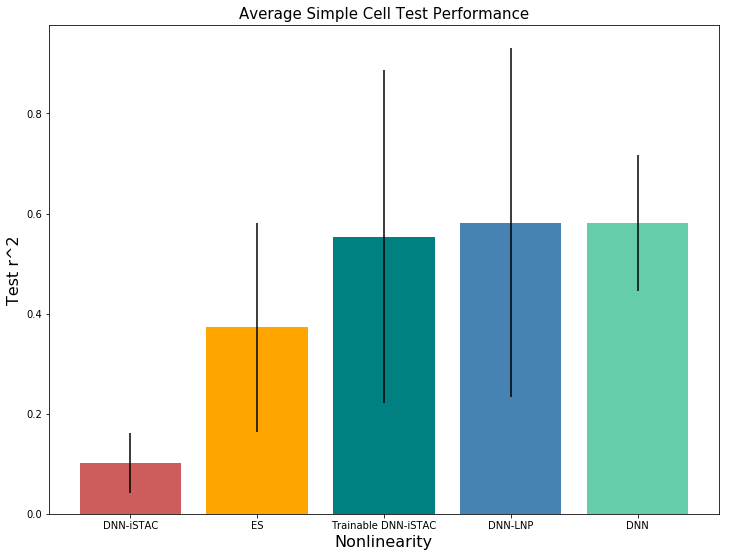

In [111]:
# plot r^2
colors = ['indianred', 'orange', 'teal', 'steelblue', 'mediumaquamarine']
cs = colors[:len(models)]
tlabels = ['DNN-iSTAC', 'ES', 'Trainable DNN-iSTAC', 'DNN-LNP', 'DNN']#[m.upper() for m in models]
X = np.linspace(1.,2.6,num=len(models))
plt.bar(X, means, width=.32, yerr=.6*np.asarray(stds), tick_label=tlabels, color=cs)
plt.legend(loc='upper right')
plt.xlabel('Nonlinearity', fontsize=16)
plt.ylabel('Test r^2', fontsize=16)
plt.title('Average %s Cell Test Performance' % (ctype[0].upper()+ctype[1:]), fontsize=15)
plt.show()

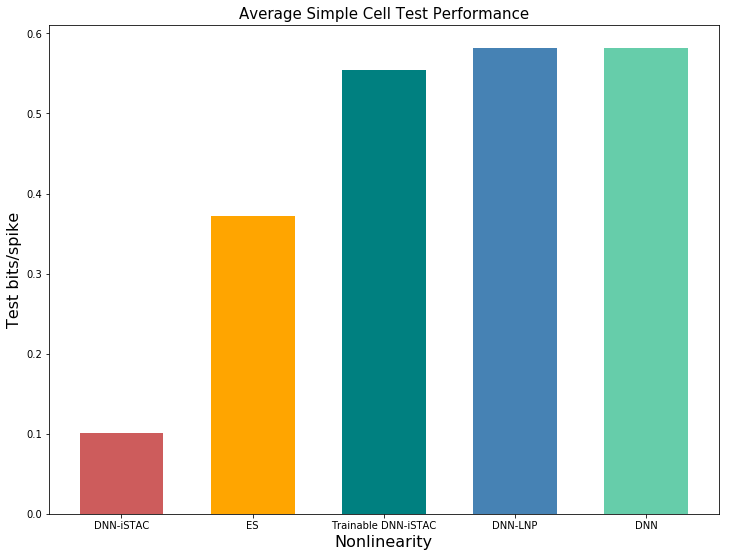

In [115]:
# plot bps
colors = ['indianred',  'orange', 'teal', 'steelblue', 'mediumaquamarine', 'cadetblue', 'red']
cs = colors[:len(models)]
tlabels = ['DNN-iSTAC', 'ES','Trainable DNN-iSTAC', 'DNN-LNP', 'DNN']#[m.upper() for m in models]
X = np.linspace(1.,3.,num=len(models))
plt.bar(X, means, width=.32, tick_label=tlabels, color=cs) #yerr=.3*np.asarray(stds),
plt.legend(loc='upper right')
plt.xlabel('Nonlinearity', fontsize=16)
plt.ylabel('Test bits/spike', fontsize=16)
plt.title('Average %s Cell Test Performance' % (ctype[0].upper()+ctype[1:]), fontsize=15)
plt.show()

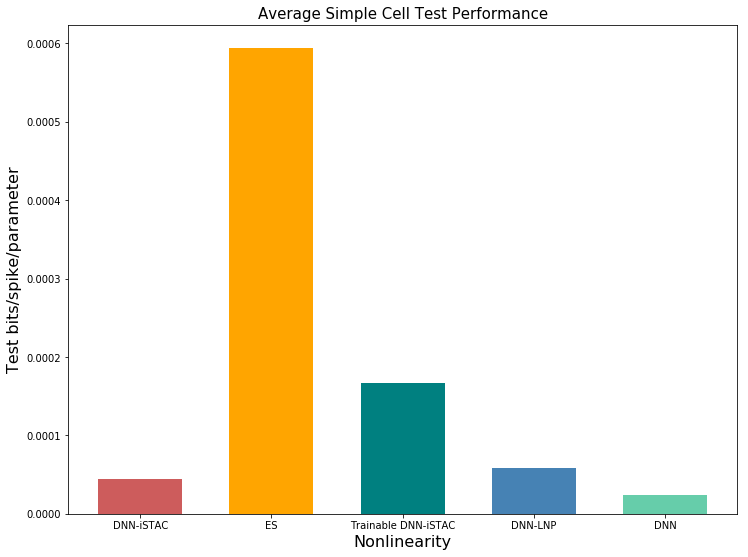

In [114]:
# plot bps/param
param_ns = {'fc_istac':2305, 'es':627, 'fc_istac_tr':3333, 'fc_filts':10054, 'fc':24833}
p_ns = [2305, 627, 3333, 10054, 24833]
means_pp = [m/p for m,p in zip(means, p_ns)]
colors = ['indianred',  'orange', 'teal', 'steelblue', 'mediumaquamarine', 'cadetblue', 'red']
cs = colors[:len(models)]
tlabels = ['DNN-iSTAC', 'ES','Trainable DNN-iSTAC', 'DNN-LNP', 'DNN']#[m.upper() for m in models]
X = np.linspace(1.,3.,num=len(models))
plt.bar(X, means_pp, width=.32, tick_label=tlabels, color=cs) #yerr=.3*np.asarray(stds),
plt.legend(loc='upper right')
plt.xlabel('Nonlinearity', fontsize=16)
plt.ylabel('Test bits/spike/parameter', fontsize=16)
plt.title('Average %s Cell Test Performance' % (ctype[0].upper()+ctype[1:]), fontsize=15)
plt.show()

In [24]:
len(means)

3

# 2. PSTHs

In [8]:
def plot_psth(models, celltype, cell_num, metric='r2', data=None, window=(0,-1)):
    #cell_num = np.where(data==np.max(data))[2][0]+1 if data is not None else 
    v1 = V1(celltype, cell_num, verbose=False)
    plt.imshow(v1.rpt_raster[:,window[0]:window[1]])
    plt.ylabel('Repeat #')
    plt.title('Raster')
    plt.show()
    
    
    plt.plot(v1.psth[window[0]:window[1]], label='Repeat Data', color='black')
    
    
    for m in models:
        flatten = True if m=='fc' else False
        v1 = V1(celltype, cell_num, flatten=flatten, verbose=False)
        if m in nn_models:
            nn = get_nn_model(celltype, m, metric=metric, verbose=False)
            rpt_preds = nn.predict(v1.X_rpt)
        elif m in lnp_models:
            rpt_preds = np.asarray(eng.lnp_predict(celltype, m, v1.rpt_file)) 
        model_psth = v1.convert_psth(rpt_preds)
        plt.plot(model_psth[window[0]:window[1]], label=m.upper() if not m =='istac' else 'iSTAC')

    plt.xlabel('Time (ms)', fontsize=14)
    plt.ylabel('Spike Count', fontsize=14)
    plt.legend(fontsize=14)
    plt.title('PSTH for %s Cell' % (celltype[0].upper()+celltype[1:]), fontsize=16)
    plt.show()

In [21]:
m = 'cnn'
celltype = 'simple'
flatten = False
metric = 'bps'
cell_num = 1

v1 = V1(celltype, cell_num, flatten=flatten, verbose=False)
nn = get_nn_model(celltype, m, metric=metric, verbose=False)

SavedModels/simple_best_cnn_bps.h5


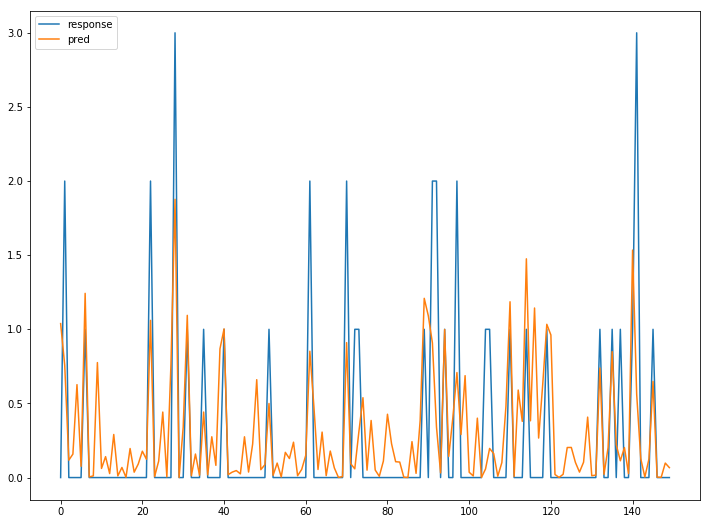

In [27]:
lo = 100
hi = 250
plt.plot(v1.y_test[lo:hi], label='response')
plt.plot(nn.predict(v1.X_test[lo:hi]), label='pred')
plt.legend()
plt.show()

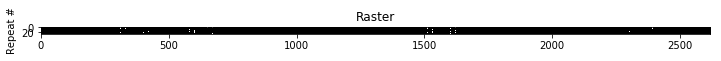

SavedModels/simple_best_cnn_bps.h5


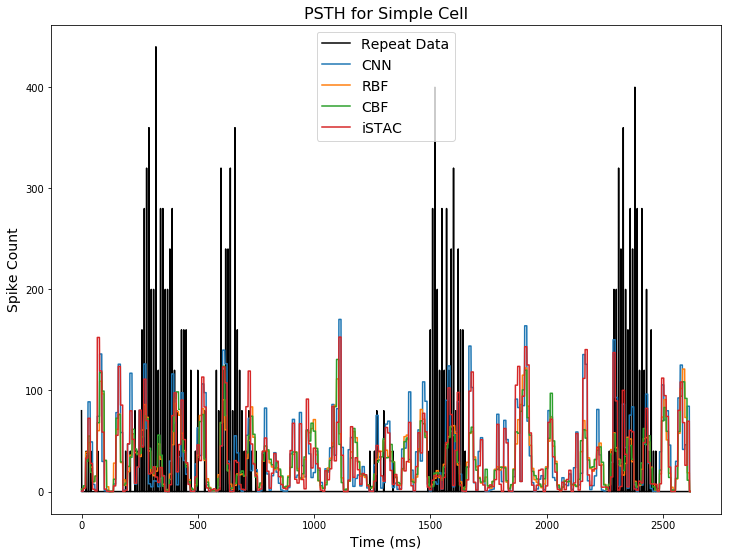

In [26]:
models = ['cnn', 'rbf', 'cbf', 'istac']
ctype = 'simple'
plot_psth(models, ctype, 1, metric='bps', window=(2500,-1))

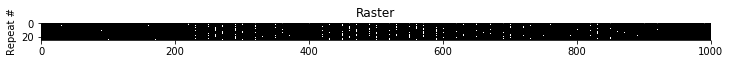

SavedModels/complex_best_cnn_r2.h5


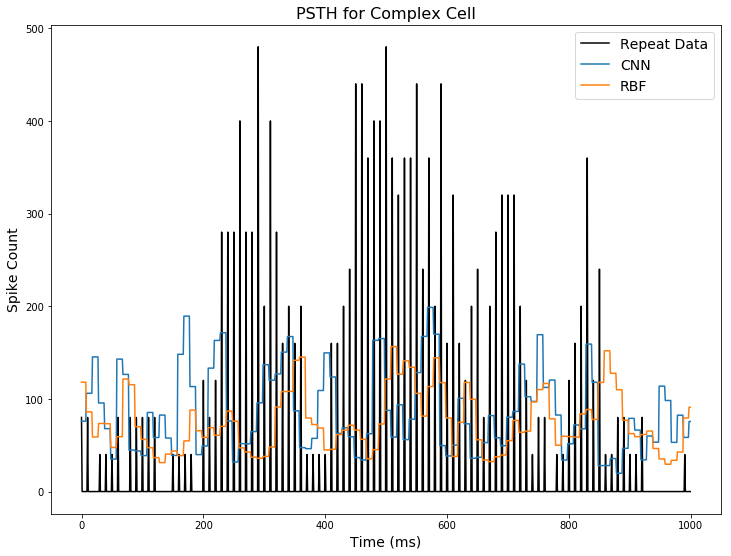

In [12]:
models = ['cnn', 'rbf']
ctype = 'complex'
plot_psth(models, ctype, 4, metric='r2', window=(2000,3000))

# Filters/Weights

In [120]:
def get_nn_wts(model, celltype, metric='r2', verbose=False, filts=False):
    nn = get_nn_model(celltype, model, metric=metric, verbose=verbose, filts=filts) 
    if verbose: nn.summary(); 
    weights = [l.get_weights() for l in nn.layers]
    return weights

def get_filts(wts):
    return wts[0][0]

In [137]:
m = load_model('SavedModels/complex_best_fc_r2.h5', custom_objects={'poiss_full':poiss_full})

In [139]:
wts = get_nn_wts('fc', 'complex', metric='r2',verbose=True, filts=False)

loading fc...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_350 (Dense)            (None, 128)               32896     
_________________________________________________________________
activation_252 (Activation)  (None, 128)               0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_351 (Dense)            (None, 1)                 129       
Total params: 33,025
Trainable params: 33,025
Non-trainable params: 0
_________________________________________________________________


In [140]:
filts = get_filts(wts)

In [141]:
filts.shape

(256, 128)

In [ ]:
def pca_reduce(filts, i):
    X = filts.reshape(-1,128)
    X -= np.mean(X, axis = 0) # zero-center the data (important)
    cov = np.dot(X.T, X) / X.shape[0] # get the data covariance matrix
    U,S,V = np.linalg.svd(cov)
    Xrot = np.dot(X, U) # decorrelate the data
    Xrot_reduced = np.dot(X, U[:,:i]) # Xrot_reduced becomes [N x i]
    return Xrot_reduced

In [ ]:
model = Sequential()
model.add(Dense(LNP, weights=[filts, np.zeros(LNP)],
                              trainable=trainable, input_dim=dim, activation='softplus', name='istac_filts'))

In [135]:
X = filts.reshape(-1,32)
X -= np.mean(X, axis = 0) # zero-center the data (important)
cov = np.dot(X.T, X) / X.shape[0] # get the data covariance matrix
U,S,V = np.linalg.svd(cov)
Xrot = np.dot(X, U) # decorrelate the data
Xrot_reduced = np.dot(X, U[:,:10]) # Xrot_reduced becomes [N x 100]

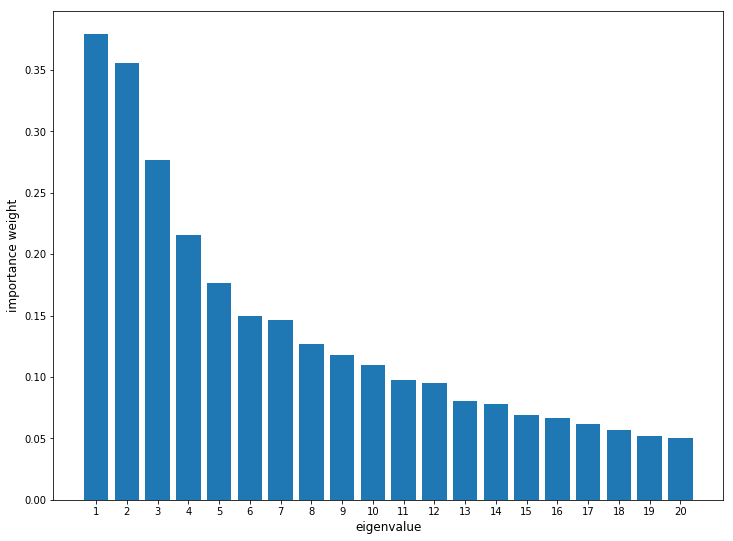

In [136]:
n = 20
plt.bar(np.arange(n)+1, S[:n])
plt.xticks(np.arange(n)+1)
plt.xlabel('eigenvalue', fontsize=12)
plt.ylabel('importance weight', fontsize=12)
plt.show()

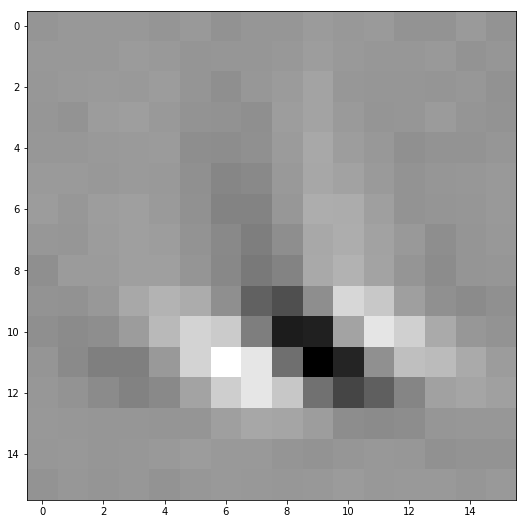

In [143]:
plt.imshow(Xrot_reduced[:,0].reshape(16,16), interpolation='nearest')
plt.show()

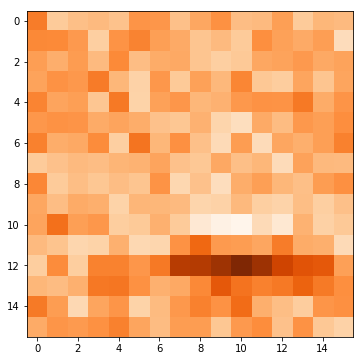

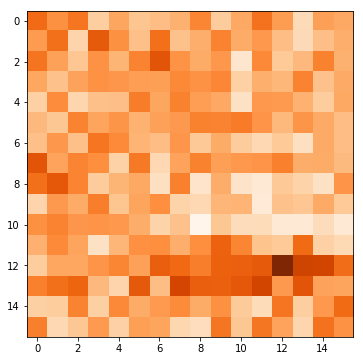

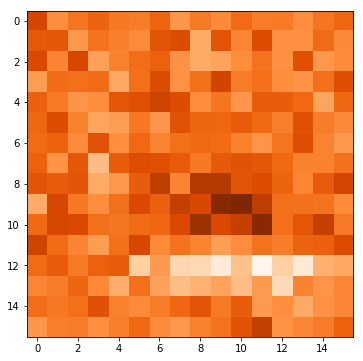

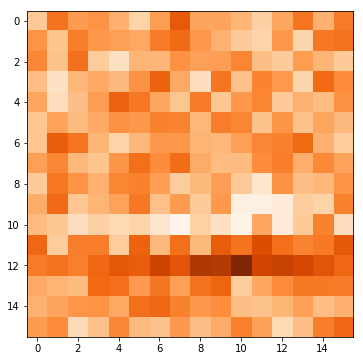

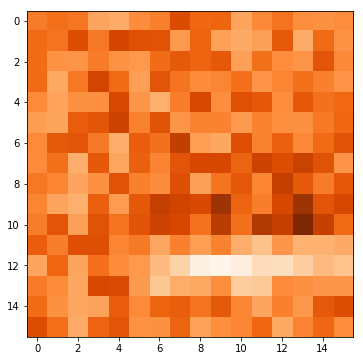

In [17]:
plt.rcParams['figure.figsize'] = (8.0, 6.0)
filts = get_filts(wts)

for i in range(filts.shape[1]):
    f = filts[:,i].reshape(-1,16)
    plt.imshow(f/np.linalg.norm(f), interpolation='nearest', cmap='Oranges')
    plt.show()

LNP Filters

In [181]:
model = 'cbf'
ctype = 'complex'

lnp_filts = np.asarray(eng.get_filters(ctype, model))

In [182]:
lnp_filts.shape

(16, 16, 5)

In [183]:
X = lnp_filts.reshape(-1,5)
X -= np.mean(X, axis = 0) # zero-center the data (important)
cov = np.dot(X.T, X) / X.shape[0] # get the data covariance matrix
U,S,V = np.linalg.svd(cov)
Xrot = np.dot(X, U) # decorrelate the data
Xrot_reduced = np.dot(X, U[:,:10]) # Xrot_reduced becomes [N x 100]

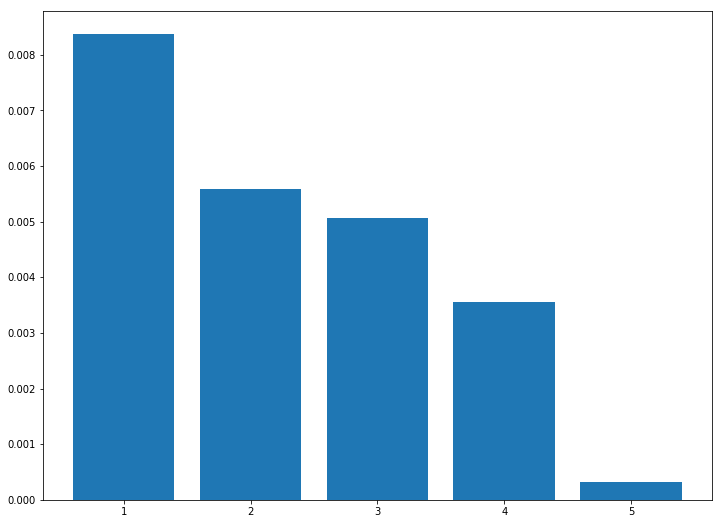

In [184]:
n = 5
plt.bar(np.arange(n)+1, S[:n])
plt.xticks(np.arange(n)+1)
plt.show()

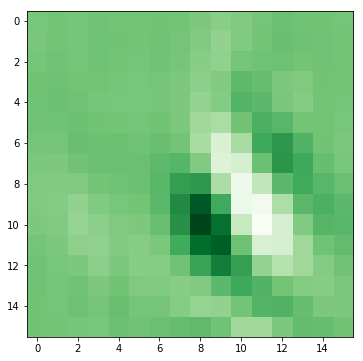

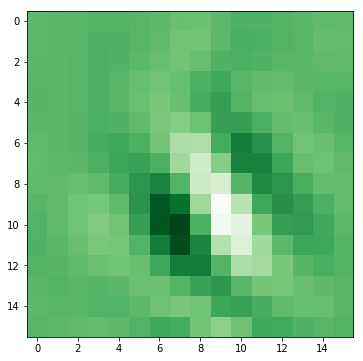

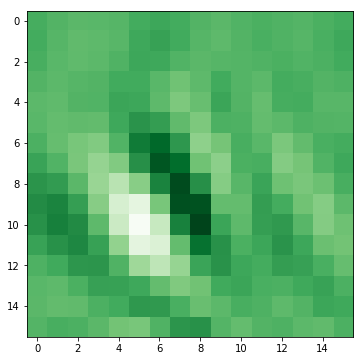

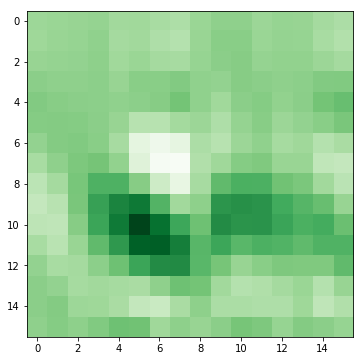

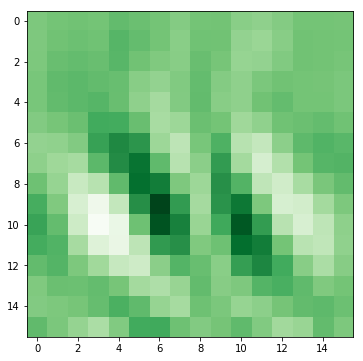

In [65]:
plt.rcParams['figure.figsize'] = (8.0, 6.0)
for i in range(lnp_filts.shape[2]):
    f = lnp_filts[:,:,i]
    plt.imshow(f/np.linalg.norm(f), interpolation='nearest', cmap='Greens') # cmap = Blues for iSTAC, Greens for R/CBF
    plt.show()

In [51]:
cbf = np.genfromtxt('SavedFilters/complex_cbf_filters_cell1.csv', delimiter=',')

IOError: SavedFilters/complex_cbf_filters_cell1.csv not found.

In [49]:
cbf = np.reshape(cbf, [16,16,5], order='F')

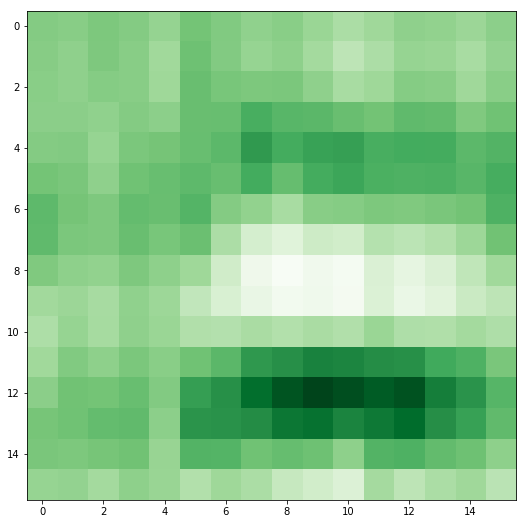

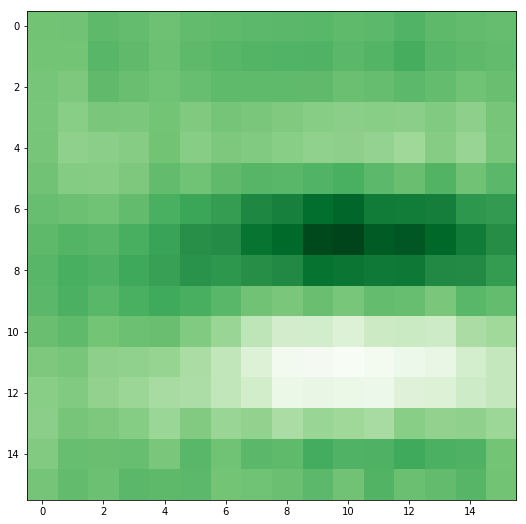

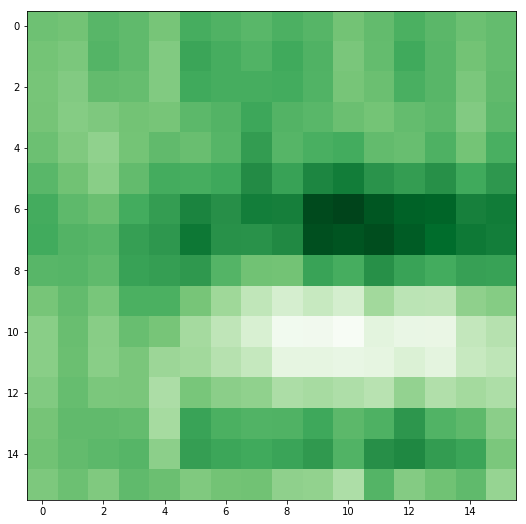

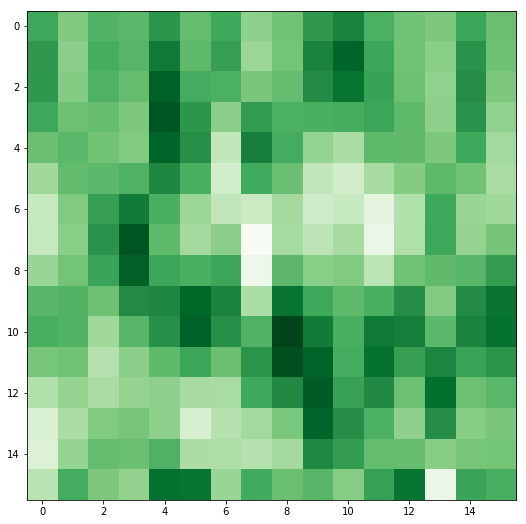

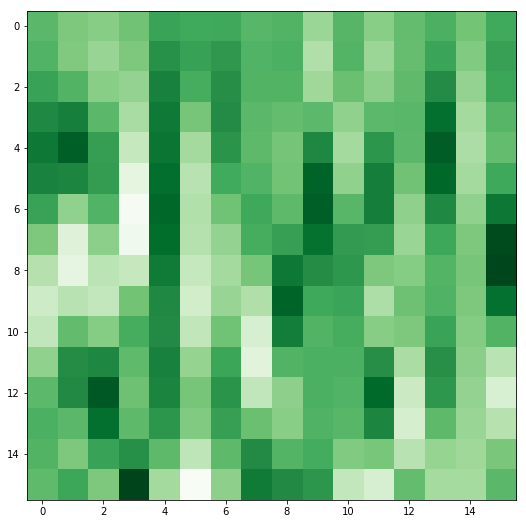

In [50]:
for i in range(5):  
    f = cbf[:,:,i] 
    plt.imshow(f / np.linalg.norm(f), interpolation='nearest', cmap='Greens')
    plt.show()

# Nonlinearities

In [2]:
import nonlinearity as nl

def get_lnp_nlin(celltype, nlin):
    return np.genfromtxt('./SavedNonlins/' + celltype + '_' + nlin + '.csv', delimiter=',')

In [9]:
celltype = 'complex'
path = 'SavedModels/2f_es_tr_' + celltype + '_best_fc_r2.h5'
#path = 'SavedModels/2_filts_' + celltype + '.h5'
model = load_model(path, custom_objects={'poiss_full': poiss_full})

In [10]:
x,y,z = nl.generate(model, bound=3.0, es=True)

72000 / 360000 points computed
144000 / 360000 points computed
216000 / 360000 points computed
288000 / 360000 points computed


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


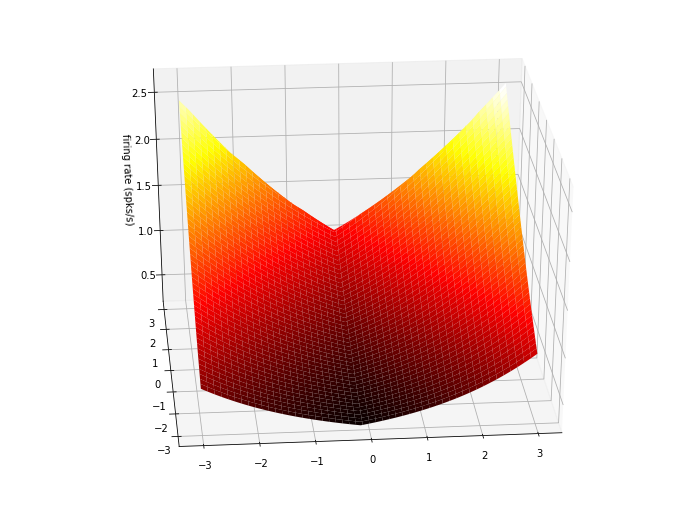

In [17]:
nl.plot([x,y,z], rot=265, cmap='hot')

In [7]:
import keras
print keras.__version__

2.0.9


In [21]:
celltype = 'simple'
z_lnp = np.asarray(eng.nonlinearity(celltype, 'cbf', 2.5))

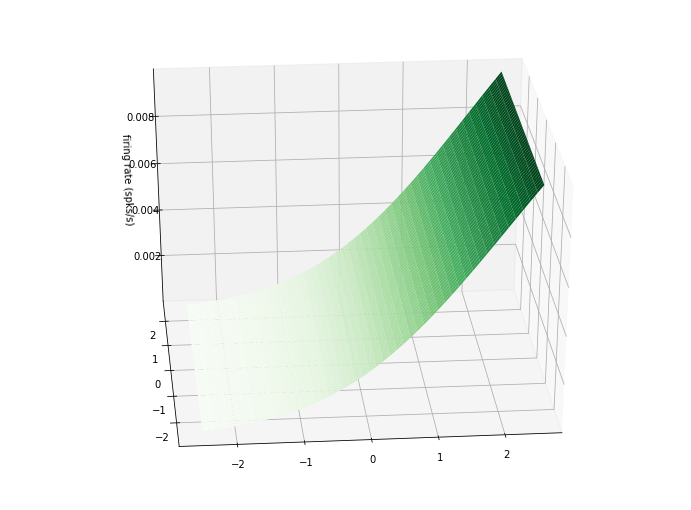

In [23]:
nl.plot([x, y, z_lnp], rot=265, cmap='Greens') #.0025 istac # .02 istac complex, .015 rbf complex, .02 cbf complex